In [1]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.5f' % x) #prevent scientific number display
%matplotlib inline

# Import Data

In [165]:
dataset = pd.read_excel('Dataset.xlsx', sheet_name = 'Data Set')
market = pd.read_excel('Dataset.xlsx', sheet_name = 'Market')

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Market ID          720 non-null    int64
 1   Year               720 non-null    int64
 2   Month              720 non-null    int64
 3   Rent               720 non-null    int64
 4   Fees               720 non-null    int64
 5   Starting Units     720 non-null    int64
 6   New Units          720 non-null    int64
 7   Lost Units         720 non-null    int64
 8   Total Nights Sold  720 non-null    int64
dtypes: int64(9)
memory usage: 50.8 KB


In [161]:
market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Market    20 non-null     object
 1   MarketId  20 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 448.0+ bytes


# Data Processing

In [169]:
# join the datasets (dataset & market)

col_drop = ['MarketId','Market ID']

org_data_set = dataset.merge(market, how = 'left', left_on = 'Market ID',
            right_on = 'MarketId' ).drop(columns = col_drop )

org_data_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 720 entries, 0 to 719
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Year               720 non-null    int64 
 1   Month              720 non-null    int64 
 2   Rent               720 non-null    int64 
 3   Fees               720 non-null    int64 
 4   Starting Units     720 non-null    int64 
 5   New Units          720 non-null    int64 
 6   Lost Units         720 non-null    int64 
 7   Total Nights Sold  720 non-null    int64 
 8   Market             720 non-null    object
dtypes: int64(8), object(1)
memory usage: 56.2+ KB


### Aggregate Transformantion

In [170]:
# Create date index, order columns and groups by date eliminating Market

from pandas.tseries.offsets import MonthEnd

org_data_set['YearMonth'] = org_data_set['Year'].astype(str)+org_data_set['Month'].astype(str)

org_data_set['Date']= pd.to_datetime(org_data_set['YearMonth'], format="%Y%m") + MonthEnd(1)

col_drop1 = ['YearMonth']
#col_drop1 = ['Year','Month', 'YearMonth'] 

column_order = ['Month','Rent','Fees','Total Nights Sold',
               'Starting Units','New Units','Lost Units']

org_data_set = org_data_set.drop(columns = 'Month').groupby('Date').sum()

org_data_set['Month'] = pd.DatetimeIndex(org_data_set.index).month
org_data_set = org_data_set.reindex(columns = column_order)#.set_index(['Date']).sort_index()

org_data_set.head()

,Month,Rent,Fees,Total Nights Sold,Starting Units,New Units,Lost Units
Date,,,,,,,
2019-01-31,1,2819632,768131,21058,1965,77,66
2019-02-28,2,3293731,802415,23777,1994,68,49
2019-03-31,3,5903504,1675303,33748,2020,411,41
2019-04-30,4,6061874,1909305,33399,2389,133,43
2019-05-31,5,6938249,2283756,37130,2463,77,55


<AxesSubplot:xlabel='Date'>

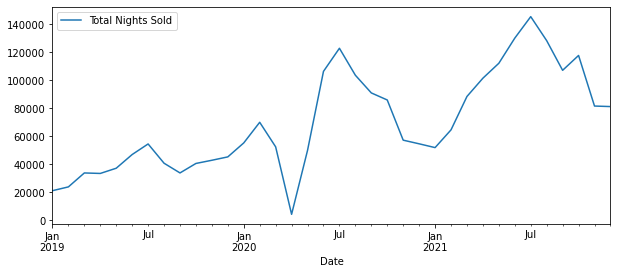

In [171]:
#Nights graph to observe data
org_data_set['Total Nights Sold'].plot.line( figsize = (10,4), legend = True )

In [176]:
# Set up data to calculate outlier months in 2020 (COVID) at Market level.
pd.options.mode.chained_assignment = None  # default='warn'

#Update as needed:
#----------------------------------------------------------------|
time_range_comparable = slice('2021-02-28','2021-06-30')# needs an additional month
time_covid_start = '2020-02-29'
time_covid_period = slice('2020-02-29','2020-05-31')
col_drop2 = ['Starting Units','New Units','Lost Units']
col_drop3 = ['Rent','Fees','Total Nights Sold']

#Gets the data needed for the calculation comparable and covid period
comparable_period = org_data_set.loc[(time_range_comparable),:].reset_index().drop(columns = col_drop2 )
time_covid_start = org_data_set.loc[(time_covid_start),:]
unchanged_cols_covid_2020 = org_data_set.loc[(time_covid_period),:].reset_index().drop(columns = col_drop3 )
#----------------------------------------------------------------|

#Update as needed:
#---------------------------------------------------------------|
col1 = 'Rent'
col2 = 'Fees'
col3 = 'Total Nights Sold'
delta_col1_name = 'Rent_delta'
delta_col2_name = 'Fees_delta'
delta_col3_name = 'Total Nights Sold_delta'

#Creates the % change from month to month
comparable_period[delta_col1_name] = comparable_period[col1].pct_change(periods = 1)
comparable_period[delta_col2_name] = comparable_period[col2].pct_change(periods = 1)
comparable_period[delta_col3_name] = comparable_period[col3].pct_change(periods = 1)
comparable_period = comparable_period.drop(columns = col_drop3).dropna()
#---------------------------------------------------------------|

#Creates date column for covid period
covid_dates = unchanged_cols_covid_2020.iloc[:,0]

In [179]:
# Recalculation of  outlier columns in months of 2020 (COVID)
#----------------------------------------------------------------|
#Update as needed:
col = 'Rent'
col_delta = col+'_delta'

#adds values to be transforms into lists
attribute = list()
attribute = [time_covid_start[col]]
pct_change = list()
pct_change = [x for x in comparable_period[col_delta]]
covid_dates = [x for x in covid_dates]
covid_outlier_ouput = dict()
    
for i in range(len(pct_change)):
    if i == 0: attribute.append(attribute[0]*(1+pct_change[0]))  
    else: attribute.append(attribute[i]*(1+pct_change[i]))
print('Recalculated'+' '+col+':',attribute[1:])
        
for i in range(len(attribute)-1):
    covid_outlier_ouput[covid_dates[i]] = attribute[i+1]
#----------------------------------------------------------------|
    
#----------------------------------------------------------------|
#Update as needed:
column_order1 = ['Month','Rent','Fees','Total Nights Sold',
               'Starting Units','New Units','Lost Units']

unchanged_cols_covid_2020[col] = unchanged_cols_covid_2020.Date.map(covid_outlier_ouput)

updated_cols_covid_2020 = unchanged_cols_covid_2020.set_index(['Date'],
                                drop = True).reindex(columns = column_order1)
updated_cols_covid_2020
#----------------------------------------------------------------|

Recalculated Rent: [19164643.998975527, 20455433.33063644, 24791077.62514242, 42275045.62593184]


,Month,Rent,Fees,Total Nights Sold,Starting Units,New Units,Lost Units
Date,,,,,,,
2020-02-29,2,19164643.99898,5842868.20481,95896.15231,5887,360,111
2020-03-31,3,20455433.33064,6813731.06730,110065.53609,6145,98,99
2020-04-30,4,24791077.62514,7827033.69850,121643.39561,6141,34,133
2020-05-31,5,42275045.62593,10224111.34004,141139.98211,6013,59,122


In [181]:
#Get data by columns without outlier and appends updated outlier data.

Agg_df = org_data_set.drop( index = covid_dates)
Agg_df = Agg_df.append(updated_cols_covid_2020).sort_index()

<AxesSubplot:xlabel='Date'>

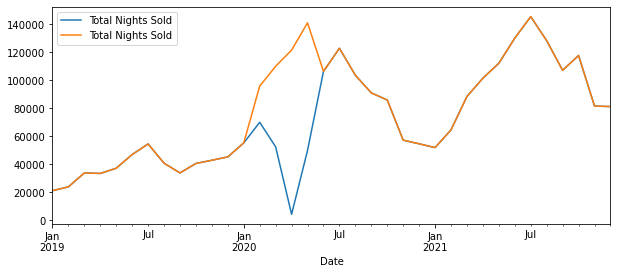

In [182]:
org_data_set['Total Nights Sold'].plot.line( figsize = (10,4), legend = True )
Agg_df['Total Nights Sold'].plot.line( figsize = (10,4), legend = True )

In [183]:
#caluculate inventory
Agg_df['inventory'] = (Agg_df['Starting Units']+Agg_df['New Units'])-Agg_df['Lost Units']

#Dummy Variables
Agg_df = pd.get_dummies(Agg_df, columns = ['Month'], drop_first = True)

In [184]:
Agg_df.head()

,Rent,Fees,Total Nights Sold,Starting Units,New Units,Lost Units,inventory,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
Date,,,,,,,,,,,,,,,,,,
2019-01-31,2819632.00000,768131.00000,21058.00000,1965,77,66,1976,0,0,0,0,0,0,0,0,0,0,0
2019-02-28,3293731.00000,802415.00000,23777.00000,1994,68,49,2013,1,0,0,0,0,0,0,0,0,0,0
2019-03-31,5903504.00000,1675303.00000,33748.00000,2020,411,41,2390,0,1,0,0,0,0,0,0,0,0,0
2019-04-30,6061874.00000,1909305.00000,33399.00000,2389,133,43,2479,0,0,1,0,0,0,0,0,0,0,0
2019-05-31,6938249.00000,2283756.00000,37130.00000,2463,77,55,2485,0,0,0,1,0,0,0,0,0,0,0
